# 17. QLS - Model Misspecification

Model specification is the selection of a function to fit the data to. We need to select:

- the dependent variable(s).
- the independent variable(s).
- the functional form.

E.g. We can assume that the dependent variable is a linear function of two independent variables. If the model is miss-specified, regression assumptions are violated and it's not accurate. Below are some of the common model specification errors.

In [32]:
import numpy as np
import pandas as pd
import seaborn as sb
sb.set(rc={'figure.figsize':(11.7,8.27)})
sb.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
import statsmodels.api as sm
from statsmodels import regression
import yfinance as yf

## Exclusion of Important Variables

If we omit a variable that is uncorrelated with the variables we *do* include, we won't explain the dependent variable as good as possible. But, if the omitted variable ($X_{2}$) is correlated with the included variable ($X_{1}$), then the omission affects the model. The coefficient of $X_{1}$, and the constant term in the regression will be biased by trying to compensate for the omission of $X_{2}$. This leads to an overestimation of the effect of $X_{1}$ on the dependent variable.

Estimated values of the coefficients and estimated standard errors will be **inconsistent**.

More specifically, we might believe that two variables have a causal relationship due to their high correlation, when in reality they're caused by a third. E.g. If two stocks follow the market, or two quantities increase with time, they'll be correlated.

In [33]:
# pull the pricing data from our two stocks and SPY
start = "2013-01-01"
end = "2015-01-01"

bench = yf.download("SPY", start, end)
a1 = yf.download("LRCX", start, end)
a2 = yf.download("AAPL", start, end)
bench = bench["Adj Close"]
a1 = a1["Adj Close"]
a2 = a2["Adj Close"]

# perform linear regression and print R-squared values
slr12 = regression.linear_model.OLS(a2, sm.add_constant(a1)).fit()
slrb1 = regression.linear_model.OLS(a1, sm.add_constant(bench)).fit()
slrb2 = regression.linear_model.OLS(a2, sm.add_constant(bench)).fit()

print("R² values of linear regression:")
print("LRCX & AAPL:", slr12.rsquared)
print("LRCX & SPY:", slrb1.rsquared)
print("AAPL & SPY:", slrb2.rsquared)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
R² values of linear regression:
LRCX & AAPL: 0.9206425831374132
LRCX & SPY: 0.8818482967959338
AAPL & SPY: 0.8241915357439109


It's hard to see consistency, or a lack of consistency, since it's asymptotic and probabilistic. However, if we extend the sample period we see how the $R^{2}$ changes. The correlation between the stocks and the market seems to persist, while the correlation of the pair drops.

In [34]:
# pull the pricing data from our two stocks and SPY
start = "2010-01-01"
end = "2016-01-01"

bench = yf.download("SPY", start, end)
a1 = yf.download("LRCX", start, end)
a2 = yf.download("AAPL", start, end)
bench = bench["Adj Close"]
a1 = a1["Adj Close"]
a2 = a2["Adj Close"]

# perform linear regression and print R-squared values
slr12 = regression.linear_model.OLS(a2, sm.add_constant(a1)).fit()
slrb1 = regression.linear_model.OLS(a1, sm.add_constant(bench)).fit()
slrb2 = regression.linear_model.OLS(a2, sm.add_constant(bench)).fit()

print("R² values of linear regression:")
print("LRCX & AAPL:", slr12.rsquared)
print("LRCX & SPY:", slrb1.rsquared)
print("AAPL & SPY:", slrb2.rsquared)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
R² values of linear regression:
LRCX & AAPL: 0.6458818238954711
LRCX & SPY: 0.7792922207689141
AAPL & SPY: 0.8120936050936037


The best way to avoid this issue is to perform qualitative analysis and pick the independent variables **before** starting the regression analysis.

## Inclusion of Unnecessary Variables

Conversely, we can have a model that includes **too many** independent variables. If we include unnecessary variables, then we'll have a lower adjusted $R^{2}$ and a less precise estimate — i.e. the analysis of the model is weaker, but the model doesn't change.

However, if we include *irrelevant* variables the fit, and the $R^{2}$, are artificially improved — by adding bits of the slightly-correlated variables that conform the sample.

E.g. Below we run a regression with PEP price as the independent variable, and PG price as the dependent variable (which intuitively makes sense since they're in the same sector), then run another regression with three random stocks added in.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SLR R²: 0.789735385019066
MLR R²: 0.8033841026463167


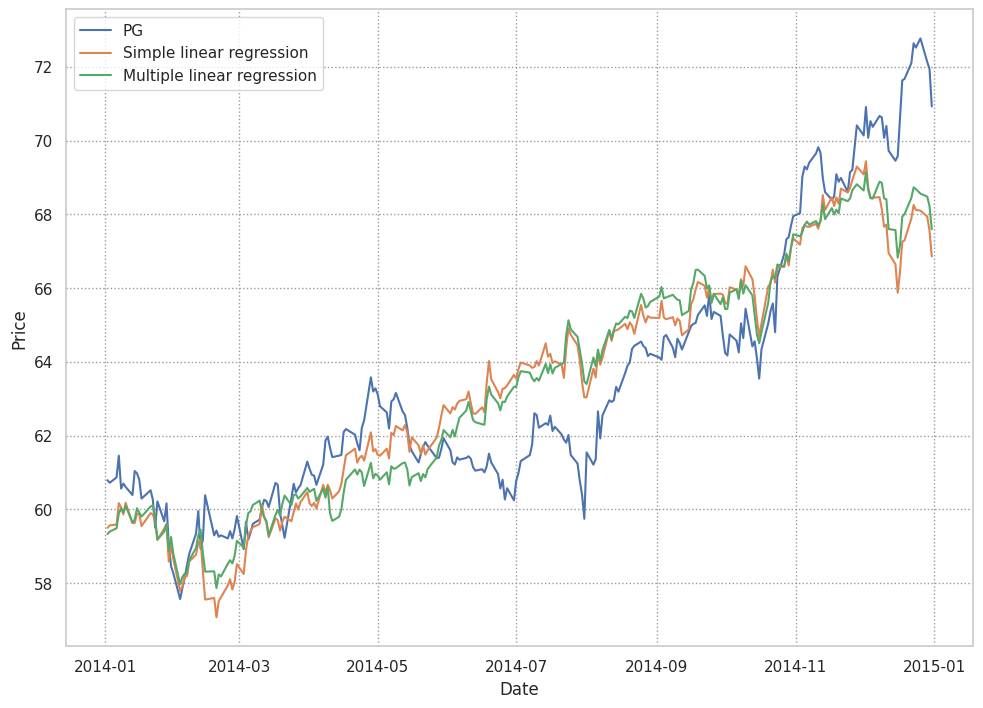

In [35]:
# load one year's worth of pricing data for five different assets
start = "2014-01-01"
end = "2015-01-01"

x1 = yf.download("PEP", start, end)
x1 = x1["Adj Close"]
x2 = yf.download("MCD", start, end)
x2 = x2["Adj Close"]
x3 = yf.download("WFC", start, end)
x3 = x3["Adj Close"]
x4 = yf.download("SPY", start, end)
x4 = x4["Adj Close"]
y =  yf.download("PG", start, end)
y = y["Adj Close"]

# build a linear model using only x1 to explain y
slr = regression.linear_model.OLS(y, sm.add_constant(x1)).fit()
slr_prediction = slr.params[0] + slr.params[1]*x1

# run multiple linear regression using x1, x2, x3, x4 to explain y
mlr = regression.linear_model.OLS(y, sm.add_constant(np.column_stack((x1,x2,x3,x4)))).fit()
mlr_prediction = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# compute adjusted R² for the two different models
print("SLR R²:", slr.rsquared_adj)
print("MLR R²:", mlr.rsquared_adj)

# plot y along with the two different predictions
sb.lineplot(y, label="PG")
sb.lineplot(slr_prediction, label="Simple linear regression")
sb.lineplot(mlr_prediction, label="Multiple linear regression").set(xlabel="Date", ylabel="Price");

The more variables there are, the more finely tuned the model is to the data. Although the adjusted $R^{2}$ penalizes the use of more variables, the sample is so large that the adjustment is small. Let's see what happens when we use the same models to predict the price of PG in the next months.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
SLR R-squared:  -0.8113348327645915
MLR R-squared:  -0.9261364329709934


1

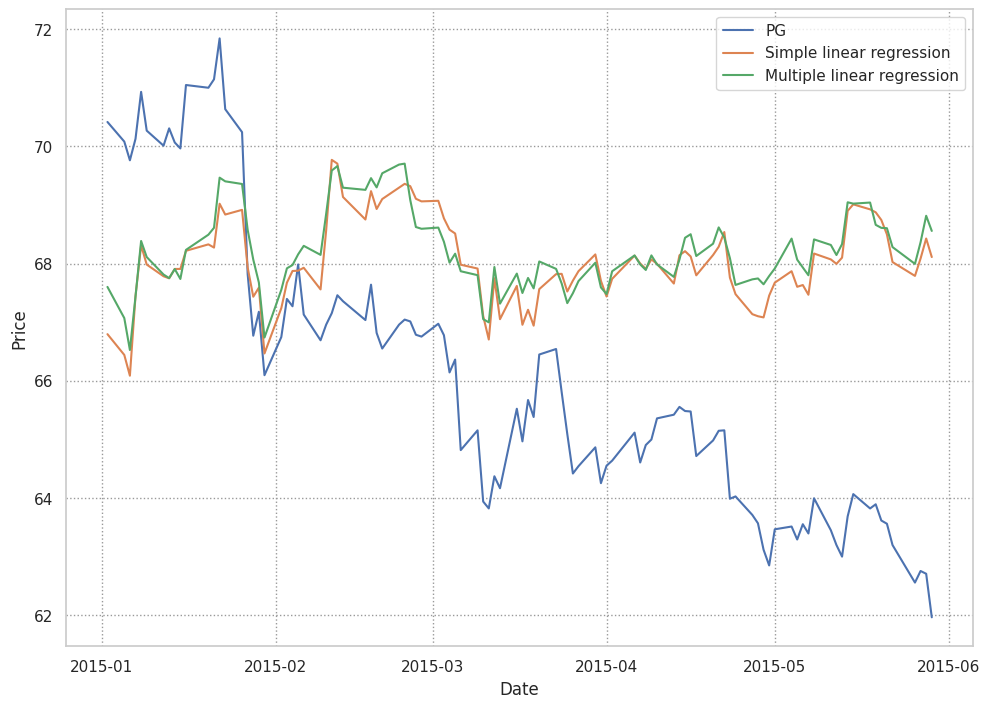

In [36]:
# load one year's worth of pricing data for five different assets
start = "2015-01-01"
end = "2015-06-01"

x1 = yf.download("PEP", start, end)
x1 = x1["Adj Close"]
x2 = yf.download("MCD", start, end)
x2 = x2["Adj Close"]
x3 = yf.download("WFC", start, end)
x3 = x3["Adj Close"]
x4 = yf.download("SPY", start, end)
x4 = x4["Adj Close"]
y =  yf.download("PG", start, end)
y = y["Adj Close"]

# extend our model from before to the new time period
slr_prediction2 = slr.params[0] + slr.params[1]*x1
mlr_prediction2 = mlr.params[0] + mlr.params[1]*x1 + mlr.params[2]*x2 + mlr.params[3]*x3 + mlr.params[4]*x4

# compute adjusted R-squared over the extended time period
adj = float(len(y) - 1)/(len(y) - 5) # Compute adjustment factor
SST = sum((y - np.mean(y))**2)
SSRs = sum((slr_prediction2 - y)**2)
print("SLR R-squared: ", 1 - adj*SSRs/SST)
SSRm = sum((mlr_prediction2 - y)**2)
print("MLR R-squared: ", 1 - adj*SSRm/SST)

# plot y along with the two different predictions
sb.lineplot(y, label="PG")
sb.lineplot(slr_prediction2, label="Simple linear regression")
sb.lineplot(mlr_prediction2, label="Multiple linear regression").set(xlabel="Date", ylabel="Price");1

Now both models perform poorly — i.e they don't hold up out of sample. In particular, the MLR model is doing worse than the SLR model. Although this performance can be attributed to anything, we shouldn't be surprised since it has no predictive power.

## Errors in Independent Variables

Indexes or dates are error free when it comes to independent variables. But, using the value of a stock $X_{t}$ as our independent variable holds a lot of errors — since the price is full of random fluctuations. So, we actually observe $Z_{t} = X_{t} + u_{t}$ for some error $u_{t}$. Our model is:

$$Y_{t} = b_{0} + b_{1} Z_{t} + (-b_{1} u_{t} + \epsilon_{t})$$

If $u_{t}$ is not correlated with $X_{t}$, then it will be correlated with $Z_{t}$ meaning the error term $-b_{1} u_{t} + \epsilon_{t})$ will be correlated with our independent variable $Z_{t}$. Due to this, the coefficients will be biased and inconsistent. Primarily, $b_{1}$ will be downwards biased.

## Incorrect Functional Form

After picking the variables to include, a shape for the function is specified. Although a regression requires that the function is linear in the coefficients, we can manipulate the variables to achieve many functions. E.g. The model $Y_{i} = b_{0} = b_{1} X_{i}^{2} + \epsilon_{i}$ gives a quadratic relationship between $X$ and $Y$, while the log-linear model $\ln Y_{i} = b_{0} = b_{1} X_{i} + \epsilon_{i}$ gives an exponential one. Generally, the form is selected on the *expectation* of the relationship: e.g. a log-linear model is good when the *rate of growth* of $Y$ is related to $X$.

If the wrong form is selected then a good fit isn't found. E.g. if we use a linear model where a log one would be more appropriate, then a prediction might be negative when it is in fact zero.

Care must be taken so as to not pick a functional form that **over-fits** the data. Using high-degree polynomials arbitrarily leads to overfitting since they have more degrees of freedom. Likewise, data-mining (trying different models until finding the *best fit*) over-fits to the sample at the expense of future predictivity.

## Pooling Different Populations

If we try and use one model for two populations (of which separate models would be better) we get misleading results. E.g. If we mix data about men/women's wages, there will be too much spread to find a fit.

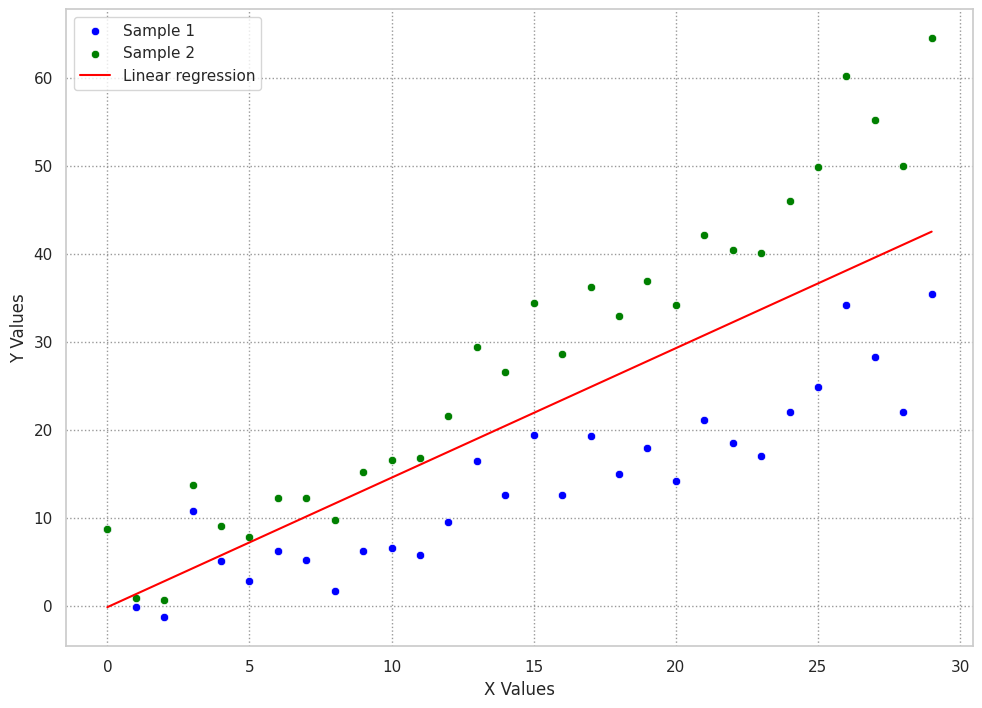

In [37]:
# generate two artificial samples and pool them
sample1 = np.arange(30) + 4*np.random.randn(30)
sample2 = sample1 + np.arange(30)
pool = np.hstack((sample1, sample2))

# run a regression on the pooled data, with the independent variable being the original indices
model = regression.linear_model.OLS(pool, sm.add_constant(np.hstack((np.arange(30),np.arange(30))))).fit()

# plot the two samples along with the regression line
sb.scatterplot(x=np.arange(30), y=sample1, label="Sample 1", color="blue")
sb.scatterplot(x=np.arange(30), y=sample2, label="Sample 2", color="green")
sb.lineplot(model.params[0] + model.params[1]*np.arange(30), label="Linear regression", color="red").set(xlabel="X Values", ylabel="Y Values");

It's clear that two separate models for the datasets is more appropriate. Note that this can lead to assumption violations like heteroskedacticity and errors not normally distributed.

On the flip side, we can pool observations that show **no** correlation, but appear to fit a model when taken together. Consider a model that compares companies' free cash flow with cash flow from operations. There's a correlation between the two if the company has a market cap of over $100 million. But, if we scale both datasets by the revenue, then the fit is insignificant. Meaning the correlation between free cash flow and cash flow from operations is **dependent** on company size, thus doesn't provide information.

In general, to compare data from different populations, we can analyse them individually or adjust for the differences between them. Often, the variables are expressed as ratios (scaling by company revenue, or average wages, etc)

## Non-Stationary Time Series

A stationary process is one in which its probability distribution doesn't change over time. Specifically, its mean and variance are *constant*. When regression models are applied to time series, we assume they are stationary. Otherwise, the t-statistics for the parameters aren't valid.

A **random walk** is a process for which the best estimate for the next value is the previous value; if you walk randomly, the location after each step is near the location *before* the step but in an unpredictable direction. Such one-dimensional walk is described like so:

$$x_{t} = x_{t-1} + \epsilon_{t}$$

Where the error $\epsilon_{t}$ is homoskedastic, has mean $0$, and is not autocorrelated. E.g. Exchange rates are often assumed to be random walks. Variance increases with time in random walks, meaning they aren't stationary. Two random walks will often appear highly correlated, they're spurious.

### All the walks

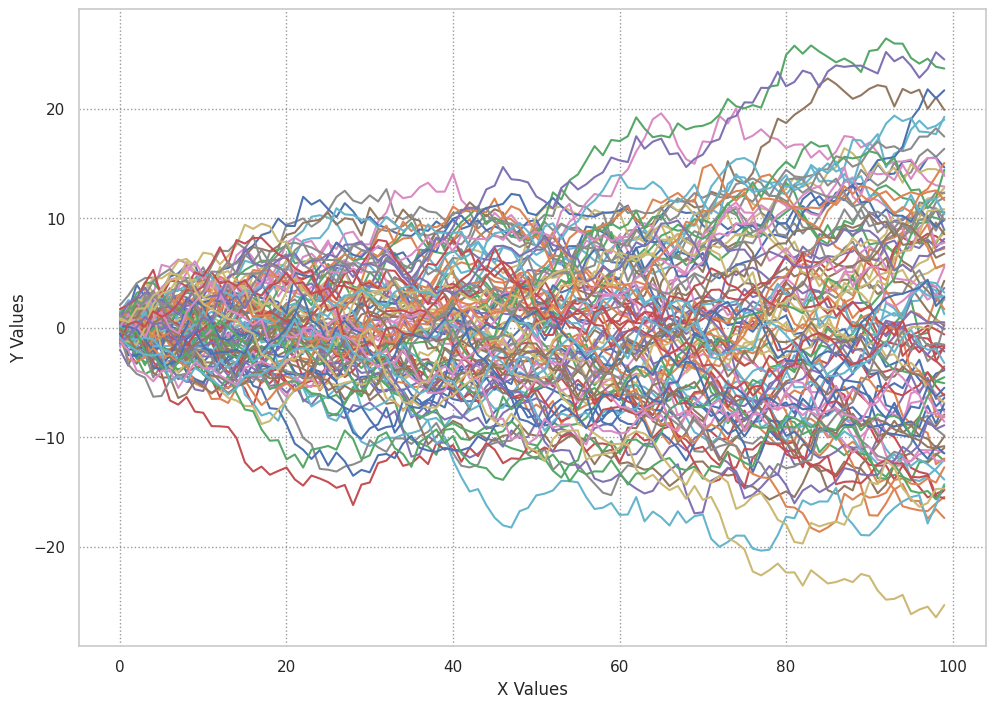

In [38]:
# generate normally distributed errors
randos = [np.random.randn(100) for i in range(100)]
y = np.random.randn(100)
# generate random walks
randows = [[sum(rando[:i+1]) for i in range(100)] for rando in randos]
yw = [sum(y[:i+1]) for i in range(100)]

for i in range(100):
    sb.lineplot(randows[i]).set(xlabel="X Values", ylabel="Y Values")

### Just those correlated with a randomly chosen one

Linearly related walks out of 100: 0


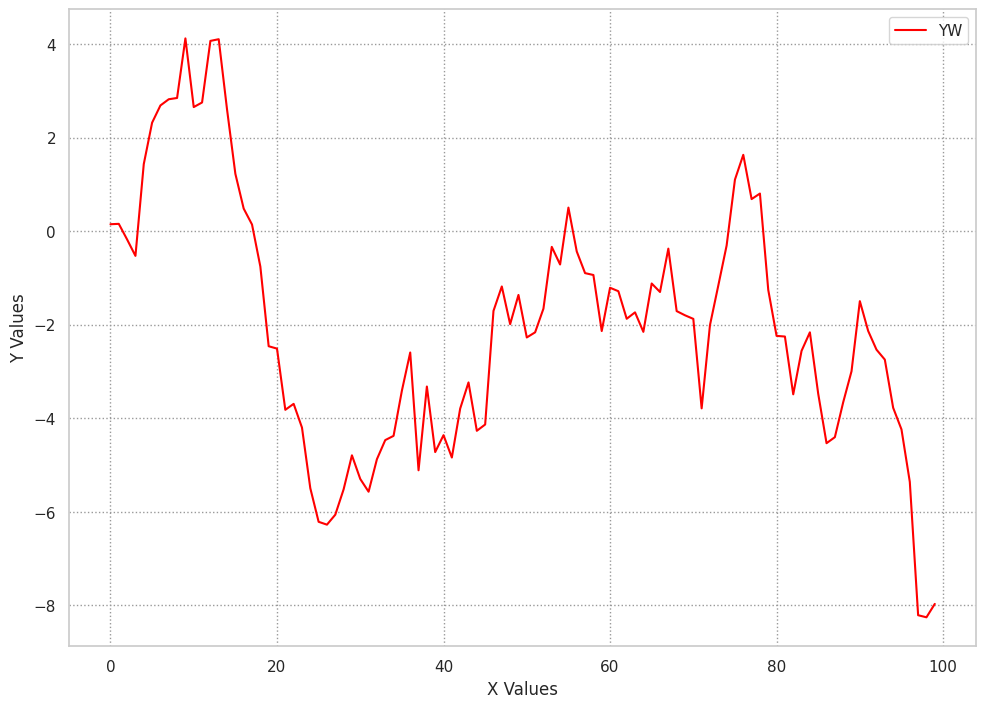

In [39]:
# compute R-squared of linear regression for each element of randows with yw
rs = [regression.linear_model.OLS(yw, x).fit().rsquared for x in randows]

# plot and count the random walks that have R-squared with yw > .8
rcount = 0
for i in range(100):
    if rs[i] > .8:
        rcount += 1
        sb.lineplot(randows[i])

# plot yw
sb.lineplot(yw, color="red", label="YW").set(xlabel="X Values", ylabel="Y Values")
print("Linearly related walks out of 100:", rcount)

A linear fit works well for positively/negatively correlated variables, hence the branches. The result is more extreme if we look at spurious random walks, according to the p-values of their correlation coefficients.

Significantly correlated walks out of 100: 59


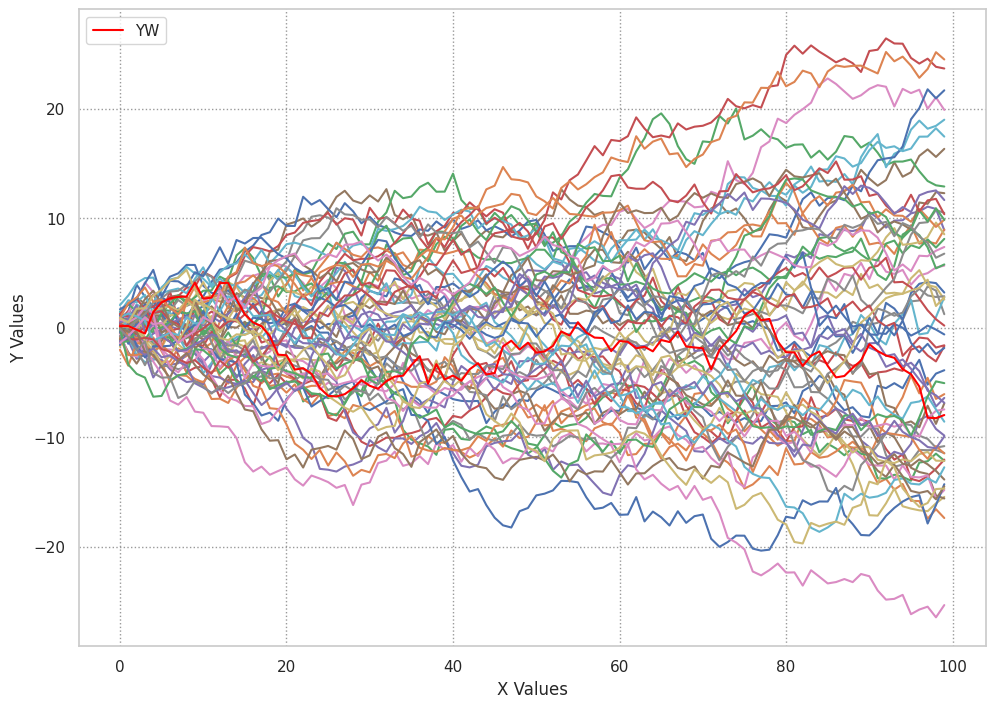

In [40]:
from scipy.stats import pearsonr

# compute correlation coefficients (Pearson r) and record their p-values
ps = [pearsonr(yw, x)[1] for x in randows]

# plot and count the random walks that have p-value of correlation with yw < 0.05
pcount = 0
for i in range(100):
    if ps[i] < .05:
        pcount += 1
        sb.lineplot(randows[i])

# plot yw
sb.lineplot(yw, color="red", label="YW").set(xlabel="X Values", ylabel="Y Values")

print("Significantly correlated walks out of 100:", pcount)

Because of the high probability of spurious results, the fit statistics computed on random walks are invalid. The parameter estimates are inconsistent.

We can **detect** random walks and related time series by checking for a *unit root* in them; meaning, whether or not it appears to follow the equation $x_{t} = x_{t-1} + \epsilon_{t}$. One method is using the Dickey-Fuller test:

In [41]:
from statsmodels.tsa.stattools import adfuller

# compute the p-value of the Dickey-Fuller statistic to test the null hypothesis that yw has a unit root
print(adfuller(yw)[1])

0.6460333096178477


Therefore we **cannot** reject the hypothesis that `yw` has a unit root (we know it does, by construction).

If we know that a time series has a *unit root,* and we'd like to analyse it anyway, we can model the **first** differenced series $y_{t} = x_{t} - x_{t-1}$ if that is stationary, and use it to predict values of $x$. We can also use regression if the dependent **and** independent variables are time series with unit roots, and the two are cointegrated.